In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
w = pywt.Wavelet('db1') #он же Хаар
print(w)

Wavelet db1
  Family name:    Daubechies
  Short name:     db
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [3]:
w.dec_lo

[0.7071067811865476, 0.7071067811865476]

In [4]:
w.dec_hi

[-0.7071067811865476, 0.7071067811865476]

In [5]:
w.dec_len

2

In [6]:
sample_signal = np.arange(8)
pywt.dwt_max_level(sample_signal.size, w.dec_len)

3

Попробуем проверить принцип работы.

In [7]:
ca, cd = pywt.dwt(sample_signal, w)
print(ca)
print(cd)

[0.70710678 3.53553391 6.36396103 9.19238816]
[-0.70710678 -0.70710678 -0.70710678 -0.70710678]


In [8]:
for i in range(4):
    print(np.inner(w.dec_lo[::-1], sample_signal[2 * i:2 * i + 2]))
print()
for i in range(4):
    print(np.inner(w.dec_hi[::-1], sample_signal[2 * i:2 * i + 2]))

0.7071067811865476
3.5355339059327378
6.363961030678928
9.192388155425117

-0.7071067811865476
-0.7071067811865477
-0.7071067811865475
-0.707106781186547


У Хаара --- свёртка пар (нормированные суммы / разности).

In [9]:
dec = pywt.wavedec(sample_signal, w)
len(dec)

4

Максимально простой код, дабы был понятен принцип.

In [10]:
dec_manual = []
ca_cur = sample_signal
for i in range(3): #в общем случае log_2 sample_signal.size, если длина --- степень двойки
    new_len = len(ca_cur) // 2
    ca_new = np.empty(new_len)
    cd_new = np.empty(new_len)
    for j in range(new_len):
        ca_new[j] = np.inner(w.dec_lo[::-1], ca_cur[2 * j:2 * j + 2])
        cd_new[j] = np.inner(w.dec_hi[::-1], ca_cur[2 * j:2 * j + 2])
    dec_manual = [cd_new] + dec_manual
    ca_cur = ca_new
dec_manual = [ca_cur] + dec_manual

In [11]:
assert len(dec) == len(dec_manual)
for i in range(len(dec)):
    assert dec[i].size == dec_manual[i].size
    assert np.allclose(dec[i], dec_manual[i])

In [12]:
w = pywt.Wavelet('db2')
print(w)

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [13]:
print(w.dec_lo, w.dec_hi, sep='\n')

[-0.12940952255126037, 0.2241438680420134, 0.8365163037378079, 0.48296291314453416]
[-0.48296291314453416, 0.8365163037378079, -0.2241438680420134, -0.12940952255126037]


In [14]:
sample_signal = np.arange(16)
pywt.dwt_max_level(sample_signal.size, w.dec_len)

2

In [15]:
ca, cd = pywt.dwt(sample_signal, w)
print(ca)
print(cd)

[ 0.35355339  0.89657547  3.7250026   6.55342972  9.38185685 12.21028397
 15.0387111  17.86713822 20.85965005]
[-6.12372436e-01 -2.77555756e-17  1.11022302e-16  4.44089210e-16
  0.00000000e+00  1.33226763e-15  8.88178420e-16  4.44089210e-16
  6.12372436e-01]


16 элементов переходят в 9 элементов... По какому принципу?

In [16]:
np.inner(sample_signal[:4], w.dec_lo[::-1])

0.8965754721680537

Свёртка с первой четвёркой даёт второй элемент выхода.

mode в ```pywt.dwt``` по умолчанию symmetric, так что есть предположение о принципе получения первого элемента.

In [17]:
first_frame = np.array([1, 0, 0, 1])
#сигнал: 0, 1, ..., 11, а мы взяли и развернули симметричным образом начало
np.inner(first_frame, w.dec_lo[::-1])

0.3535533905932738

Кажется, именно так!

In [18]:
np.inner(first_frame, w.dec_hi[::-1])

-0.6123724356957945

In [19]:
np.inner(sample_signal[2:6], w.dec_lo[::-1]) #[2, 3, 4, 5]

3.725002596914244

Третий фрагмент!

Кажется, стал понятен принцип... Отражаем слева и справа 2 элемента, затем сворачиваем. Новое количество элементов: $len/2 + 1$.

In [20]:
np.inner([14, 15, 15, 14], w.dec_lo[::-1]) #в конце

20.85965004500315

In [21]:
pywt.dwt(sample_signal, w, mode='periodic')

(array([19.17981582,  0.89657547,  3.7250026 ,  6.55342972,  9.38185685,
        12.21028397, 15.0387111 , 17.86713822, 19.17981582]),
 array([-5.65685425e+00, -2.77555756e-17,  1.11022302e-16,  4.44089210e-16,
         0.00000000e+00,  1.33226763e-15,  8.88178420e-16,  4.44089210e-16,
        -5.65685425e+00]))

In [22]:
np.inner([14, 15, 0, 1], w.dec_lo[::-1]) #в режиме periodic именно это идёт в начало

19.179815817539335

In [23]:
pywt.dwt(sample_signal, w, mode='zero')

(array([-0.12940952,  0.89657547,  3.7250026 ,  6.55342972,  9.38185685,
        12.21028397, 15.0387111 , 17.86713822, 19.30922534]),
 array([-4.82962913e-01, -2.77555756e-17,  1.11022302e-16,  4.44089210e-16,
         0.00000000e+00,  1.33226763e-15,  8.88178420e-16,  4.44089210e-16,
        -5.17389134e+00]))

In [24]:
np.inner([0, 0, 0, 1], w.dec_lo[::-1]) #в режиме zero именно это идёт в начало

-0.12940952255126037

In [25]:
pywt.dwt([1,2,3,4,5,6,7], w)

(array([1.76776695, 2.31078903, 5.13921616, 8.09705281, 9.93417011]),
 array([-6.12372436e-01,  1.66533454e-16,  3.33066907e-16,  4.82962913e-01,
         1.29409523e-01]))

Если нечётное число элементов --- видимо, дописываем последний в конец ещё раз (добиваем до чётного).

In [26]:
print(np.inner([5,6,7,7], w.dec_lo[::-1]))
print(np.inner([7,7,6,5], w.dec_lo[::-1]))

8.09705280658479
9.934170113672174


Хотя нет, чётный 1 2 3 4 5 6 7 7 мы бы в конце разворачивали как 7 7 7 7, а не 7 7 6 5.

In [27]:
sample_signal = np.random.rand(101)
doubled_even_signal = np.concatenate([sample_signal, sample_signal[-1:]])
assert np.all(sample_signal == doubled_even_signal[:-1])
assert doubled_even_signal[-2] == doubled_even_signal[-1]

In [28]:
dec_1 = pywt.dwt(sample_signal, w)
dec_2 = pywt.dwt(doubled_even_signal, w)
print(dec_1[0][-1])
print(dec_2[0][-1])

last_frame = [sample_signal[-1]] * 2 + [sample_signal[-2]] + [sample_signal[-3]] 
print(np.inner(last_frame, w.dec_lo[::-1])) #как у sample_signal
last_frame = [sample_signal[-1]] * 4
print(np.inner(last_frame, w.dec_lo[::-1])) #как у doubled_even_signal

0.683377965730269
0.7362579392718154
0.683377965730269
0.7362579392718154


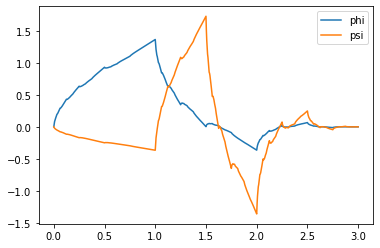

In [29]:
phi, psi, x = w.wavefun()
plt.plot(x, phi, label='phi')
plt.plot(x, psi, label='psi')
plt.legend()

In [30]:
w = pywt.Wavelet('db4')
print(w)

Wavelet db4
  Family name:    Daubechies
  Short name:     db
  Filters length: 8
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [31]:
sample_signal = np.arange(24)
pywt.dwt_max_level(sample_signal.size, w.dec_len)

1

In [32]:
ca, cd = pywt.dwt(sample_signal, w)
ca.size

15

Предположительно мы каждый раз сдвигаем фильтр на 2 и изначально прикладываем его так, что в крайнем положении 2 исходных элемента цепляются.

In [33]:
first_frame = np.concatenate([
    sample_signal[5::-1], sample_signal[:2]
])
print(np.inner(first_frame, w.dec_lo[::-1]))
print(ca[0])

5.65031790020784
5.65031790020784


In [34]:
first_frame = np.concatenate([
    sample_signal[3::-1], sample_signal[:4]
])
print(np.inner(first_frame, w.dec_lo[::-1]))
print(ca[1])

2.8165225487765038
2.8165225487765038


In [35]:
first_frame = np.concatenate([
    sample_signal[-2:], sample_signal[:-7:-1]
])
print(np.inner(first_frame, w.dec_lo[::-1]))
print(ca[-1])

32.52751833087846
32.527518330878465


Длина фильтра 8, длина сигнала 24, так что приложить целиком внутри (со сдвигами на 2) получается 9 раз (стартовые позиции: $0, 2, \ldots, 16$ соответственно).

И ещё по 3 раза в каждую из сторон посдвигать, чтобы выйти за границы переданного сигнала, дополняя его в соответствии с параметром ```mode``` из ```pywt.dwt```. Как раз $9 + 2\cdot 3 = 15$.

В общем случае, надо думать, схема такая же. В вейвлетах Добеши каждый раз сдвигаем фильтр на 2 позиции для свёртки. В результате чего вектор коэффициентов будет примерно в 2 раза меньше.

In [38]:
db = pywt.Wavelet('db4') #4 нулевых момента, то есть для полинома степени < 4 высокочастотные коэффициенты будут 0

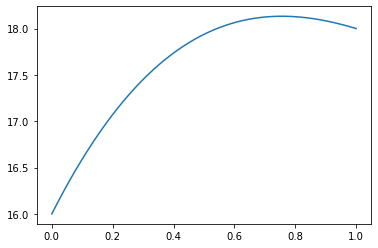

In [44]:
def poly(x):
    return 1.5 * x ** 3 - 6 * x ** 2 + 6.5 * x + 16

sample_signal = poly(np.linspace(0, 1, 256))
plt.plot(np.linspace(0, 1, 256), sample_signal)

In [49]:
coeffs = pywt.wavedec(sample_signal, db)

In [50]:
coeffs #не 0 по краям, потому что там pywt паддит (не понимаю, зачем, если честно...)

[array([ 90.84865506,  90.81561216,  90.83360775,  90.8716061 ,
         90.61003622,  91.58380374,  95.17236363,  98.15353407,
        100.283178  , 101.6618352 , 102.38908345, 102.57803523,
        102.2695286 , 101.80679774]),
 array([-3.45800768e-03, -1.95165619e-02, -1.68893706e-01,  3.37210367e-01,
        -1.10843882e-01, -1.58584607e-02, -2.44249065e-15,  1.99840144e-15,
         7.34849871e-07, -1.54896222e-03, -3.58937108e-02,  2.17345986e-02,
         4.20822547e-02, -2.12152295e-02]),
 array([-1.86994320e-03, -1.43847598e-02, -1.14545021e-01,  1.20737227e-01,
        -4.05304146e-02, -3.23439261e-03,  5.55111512e-17, -9.88098492e-15,
         5.10702591e-15, -6.32827124e-15, -7.32747196e-15,  2.22044605e-15,
        -6.43929354e-15,  1.97619698e-14, -1.66533454e-15,  5.77315973e-15,
        -1.29149897e-05, -1.82370193e-04, -1.62478405e-02,  8.43666797e-03,
         1.55593374e-02, -6.37540251e-03]),
 array([ 4.15616731e-02,  1.31207322e-01, -6.27391707e-02,  2.98955105e-02